# Applying lstm

This notebook applies lstm model on the training set to determine if each context contains a (non-ae) drug-ae pair.

In [2]:
# Using a simple LSTM to classify text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from openpyxl import load_workbook

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

In [3]:
# Name of train and test dataset
# Change according to test/train dataset chosen

train_worksheet = 'df_2009_us'# 2009 training set
test_worksheet = 'df_testing_all' # test set - 2010, 2011, MIMIC, MIMIC_unrestricted


In [ ]:
# ***************** # IMPORT TRAINING DATASET
df_tr = pd.read_excel(r'.\train undersampled.xlsx', sheet_name = train_worksheet)
df_tr.head()

In [5]:
len(df_tr)

1340

In [6]:
# ***************** # IMPORT TESTING DATASET
df_te = pd.read_excel(r'.\train and test processed.xlsx', sheet_name = test_worksheet)
print('length of test data: ', len(df_te))

length of test data:  6065


In [7]:
# FUNCTIONS FOR DATA CLEANING

# remove stopwords
stop=set(stopwords.words('english'))
def remove_stopwords(text):
    if text is not None:
        tokens = [x for x in word_tokenize(text) if x not in stop]
        return " ".join(tokens)
    else:
        return None

# stemming
porter=PorterStemmer()
def stemSentence(text):
    token_words=word_tokenize(text)
    stem_sentence =[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# remove digits
def remove_digits(text):
    digitpattern = '[0-9]'
    token_words=word_tokenize(text)
    digit_removed= [re.sub(digitpattern,'', i) for i in token_words]
    return " ".join(digit_removed)

df_tr['segment_2']=df_tr['segment_2'].apply(lambda x : remove_stopwords(x))
df_tr['segment_2']=df_tr['segment_2'].apply(lambda x : remove_digits(x))
df_tr['segment_2']=df_tr['segment_2'].apply(lambda x : stemSentence(x))

df_te['segment_2']=df_te['segment_2'].apply(lambda x : remove_stopwords(x))
df_te['segment_2']=df_te['segment_2'].apply(lambda x : remove_digits(x))
df_te['segment_2']=df_te['segment_2'].apply(lambda x : stemSentence(x))

In [ ]:
df_te.head()

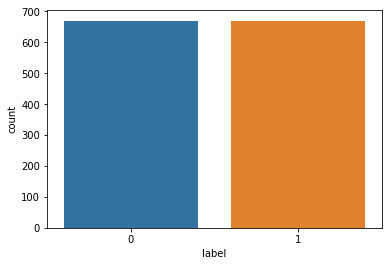

In [9]:
# Understand the distribution better
sns.countplot(df_tr.label)

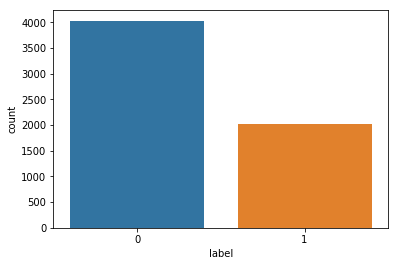

In [10]:
# Understand the distribution better
sns.countplot(df_te.label)

In [11]:
# Create input and output vectors
# process the labels

X_train=df_tr.segment_2
X_test=df_te.segment_2

le=LabelEncoder()
Y_train=df_tr.label
Y_train=le.fit_transform(Y_train)
Y_train=Y_train.reshape(-1,1)

le=LabelEncoder()
Y_test=df_te.label
Y_test=le.fit_transform(Y_test)
Y_test=Y_test.reshape(-1,1)

In [12]:
# Process the data
# Tokenize the data and convert the text to sequences
# Add padding to ensure that all the sequences have the same shape
# There are many ways of taking the max_len and here an arbitrary length of 500 is chosen

max_words = 10000
max_len = 500
embedding_dim = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [13]:
sequences_matrix

array([[   0,    0,    0, ..., 1383,  159,  930],
       [   0,    0,    0, ...,  931,  255,  606],
       [   0,    0,    0, ...,  728,  313, 1384],
       ...,
       [   0,    0,    0, ...,  205,  208,  478],
       [   0,    0,    0, ...,  248,  161,  643],
       [   0,    0,    0, ...,   17,    3,   18]])

In [14]:
# Define the RNN structure

def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, embedding_dim, input_length = max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(64, name ='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [15]:
# Call the function and compile the model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 200)          2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
FC1 (Dense)                  (None, 64)                8256      
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 65    

In [16]:
# This callback will stop the training when there is no improvement in the validation loss for 3 consecutive epochs
callback = EarlyStopping(monitor='val_loss',patience=10)

# Fit on the training data
# history = model.fit(sequences_matrix, Y_train, batch_size=10, epochs=50, validation_split=0.8)
history = model.fit(sequences_matrix, Y_train, batch_size=100, epochs=100, validation_split=0.4, callbacks=[callback])

Train on 804 samples, validate on 536 samples
Epoch 1/100
804/804 [==============================] - 62s 77ms/sample - loss: 0.5914 - accuracy: 0.8060 - val_loss: 2.5953 - val_accuracy: 0.0000e+00
Epoch 2/100
804/804 [==============================] - 73s 91ms/sample - loss: 0.4602 - accuracy: 0.8333 - val_loss: 1.2633 - val_accuracy: 0.0000e+00
Epoch 3/100
804/804 [==============================] - 79s 98ms/sample - loss: 0.4230 - accuracy: 0.8333 - val_loss: 1.9068 - val_accuracy: 0.0000e+00
Epoch 4/100
804/804 [==============================] - 87s 108ms/sample - loss: 0.3838 - accuracy: 0.8383 - val_loss: 1.2398 - val_accuracy: 0.0336
Epoch 5/100
804/804 [==============================] - 94s 117ms/sample - loss: 0.3343 - accuracy: 0.9104 - val_loss: 1.4107 - val_accuracy: 0.0765
Epoch 6/100
804/804 [==============================] - 96s 119ms/sample - loss: 0.2376 - accuracy: 0.9104 - val_loss: 1.4144 - val_accuracy: 0.2593
Epoch 7/100
804/804 [==============================] - 83

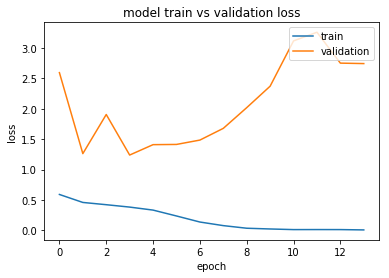

In [17]:
# Plot train and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [18]:
# Use this model on the train set to get the prediction values

train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(train_sequences, maxlen=max_len)
prediction_train = model.predict(train_sequences_matrix, verbose=0)

In [19]:
df_tr['prediction']=prediction_train

In [20]:
# Use this model on the test set

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
prediction = model.predict(test_sequences_matrix, verbose=0)

In [21]:
print(len(prediction))

6065


In [22]:
df_te['prediction']=prediction

In [ ]:
df_te.head()

## ROC CURVE

In [24]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(df_te))]

In [25]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(df_te['label'],ns_probs)
lstm_fpr, lstm_tpr, _ = roc_curve(df_te['label'],df_te['prediction'])

Text(0, 0.5, 'True Positive Rate')

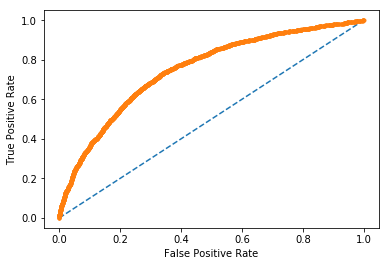

In [26]:
# plot the roc curves for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label = 'No Skill')
plt.plot(lstm_fpr, lstm_tpr, marker = '.', label = 'LSTM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [27]:
# calculate AUC
auc = roc_auc_score(df_te['label'],df_te['prediction'])
print("AUC: ",auc)

AUC:  0.7508375387248759


In [28]:
# Wrapper function to adjust class predictions based on the prediction thresholds
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y>=t else 0 for y in y_scores]

In [29]:
# set the optimal threshold
optimal_threshold = 0.5

# get the y scores for the testing set
y_pred = adjusted_classes(df_te['prediction'], optimal_threshold)
print("Confusion matrix on testing set with lstm")
print(pd.DataFrame(confusion_matrix(df_te['label'], y_pred),
                      columns=['pred_neg','pred_pos'],
                      index=['neg','pos']))  
print("\nClassification report on testing set with adjusted threshold")
print(classification_report(df_te['label'],y_pred))

Confusion matrix on testing set with lstm
     pred_neg  pred_pos
neg      1498      2536
pos       205      1826

Classification report on testing set with adjusted threshold
              precision    recall  f1-score   support

           0       0.88      0.37      0.52      4034
           1       0.42      0.90      0.57      2031

   micro avg       0.55      0.55      0.55      6065
   macro avg       0.65      0.64      0.55      6065
weighted avg       0.73      0.55      0.54      6065



## Save results to file

In [30]:
# Combine results to dataframe
lstm_results_train = pd.DataFrame({'context':df_tr['context'].tolist(),
                              'segment_2':df_tr['segment_2'].tolist(),
                              'drug':df_tr['drug'].tolist(),
                              'ae': df_tr['ae'].tolist(),
                              'label':df_tr['label'].tolist(),
                              'pred_lstm':df_tr['prediction'].tolist()
                             })

lstm_results = pd.DataFrame({'source':df_te['source'].tolist(),
                              'context':df_te['context'].tolist(),
                              'segment_2':df_te['segment_2'].tolist(),
                              'drug':df_te['drug'].tolist(),
                              'ae': df_te['ae'].tolist(),
                              'label':df_te['label'].tolist(),
                              'pred_lstm':df_te['prediction'].tolist()
                             })

In [31]:
book=load_workbook(r'./results_external_lstm.xlsx')
writer = pd.ExcelWriter(r'./results_external_lstm.xlsx', engine = 'openpyxl')
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

lstm_results_train.to_excel(writer, sheet_name = train_worksheet, index=False)
lstm_results.to_excel(writer, sheet_name = test_worksheet, index=False)

writer.save()